## Purpose  
Demonstrate how leakage can be detected using a data randomization process.  
## Process
Create fake data using linear data-generating process (DGP). Intentionally leak information and then show that this code helps detect the leakage.

In [1]:
import sys
import os
import math
import warnings

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import metrics 
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings(action='once')
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Set seed
np.random.seed(5)

In [3]:
def randomize(filepath, index_col = None, do_not_randomize = None):
    """
    Randomize column values of a file. Each column is randomized independently.
    
    Inputs:
        filepath (str): path to file to randomize; may be of type csv or txt
        index_col (str): optional name of column to use as index; will not 
            be randomized
        do_not_randomize (list): optional list of strings indicating names of 
            columns that should not be randomized
    Outputs:
        df (dataframe): dataframe representation of randomized data
        Output file will be generated, named as original file name + "_randomized"
    """
    
    # Treat csv and txt differently
    filename, file_extension = os.path.splitext(filepath)
    if file_extension == '.csv':
        sep = ","
    elif file_extension == '.txt':
        sep = "\t"
        
    # Randomize column by column
    df = pd.read_csv(filepath, sep = sep, index_col = index_col) 
    
    if do_not_randomize:
        cols = [c for c in df.columns if c not in do_not_randomize]
    else:
        cols = df.columns
        
    for col in cols:
        print('... Randomizing column ' + col)
        df[col] = np.random.permutation(df[col])
        
    # Print to new csv or txt
    new_file = filename + '_randomized' + file_extension
    df.to_csv(new_file)   
    
    return df

In [4]:
def generate_data(period, n_rows, m_columns, threshold, betas, intercept):
    
    """ 
    Generate fake data for a classification task, based on data generating process where:
    - Features are drawn iid from standard logistic distribution (location = 0, scale = 1)
    - Regression equation: y = intercept + beta_1 * x1 + .. + beta_m * xm + error
    - Error is drawn from standard normal distribution
    - Outcome is 1 if p value from logistic function exceeds threshold, 0 otherwise

    Inputs:
        period (int): time period
        n_rows (int): number of observations to generate
        m_columns (int): number of features to generate
        betas (list): list of numerical values to use as coefficients; length must equal m_columns, 
            i.e. don't include intercept
        intercept (int): constant number to use as intercept of regression equation

    Outputs:
        X (dataframe): matrix of feature variables
        y (series): outcome variable

    """
    print("Generating {} observations...".format(n_rows))

    # generate column names
    colnames = []
    for i in range(m_columns):
        colnames.append('x' + str(i + 1))

    # generate fake data
    df = pd.DataFrame(np.random.logistic(size=(n_rows, m_columns)), columns = colnames)
    df.insert(loc = 0, column = 'intercept', value = 1)
    betas = [intercept] + betas
    df['z'] = np.multiply(np.array(betas), df).sum(axis=1) + np.random.normal()
    df['pr'] = df['z'].apply(lambda x: 1/(1 + math.exp(x)))
    df['outcome'] = np.where(df['pr'] > threshold, 1, 0)
    df.index.name = 'idx'
    df['period'] = period

    return df

In [5]:
def run_logreg(X_train, y_train, X_test, y_test, plot = True, k=100):
    """
    Run logistic regression on given test and training sets   
    
    Inputs
        training and test sets
        k (int): k value for which to obtain precision at k
    
    Output
        dictionary containing logistic regresison model, test set, and evaluation metrics
    """
    # Record baseline accuracy, i.e. percentage of positives in training set
    baseline = np.mean(y_train)
    print("Baseline (% positives in training data): " + str(round(baseline, 3)))
    
    # Create a logistic regression object
    logreg = linear_model.LogisticRegression()

    # Train model with training set
    logreg.fit(X_train, y_train)

    # Make predictions with test set
    y_pred = logreg.predict(X_test)

    # Save probabilities
    probs = logreg.predict_proba(X_test)
    
    # Calculate accuracy, AUC, and precision at k
    accuracy = metrics.accuracy_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, probs[:, 1])
    
    # Print accuracy and AUC
    print("Accuracy: " + str(round(accuracy, 3)))
    print("AUC Score: " + str(round(auc, 3)))
    print("Precision at top {}: {}".format(k, get_precision_at_k(y_test, y_pred, probs[:,1], k)))

    # Print confusion matrix
    print(metrics.confusion_matrix(y_test, y_pred))
    
    if plot:
        # Plot AUC curve (source: https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/)
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, probs[:,1])
        #print("FP rate: ", false_positive_rate, "TP rate: ", true_positive_rate)
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% auc)
        plt.legend(loc='lower right')
        plt.plot([0,1],[0,1],'r--')
        plt.xlim([-0.1,1.2])
        plt.ylim([-0.1,1.2])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    # Create output dictionary
    output = {'model': logreg, 'baseline': baseline, 'X_test': X_test, 'y_test': y_test, 'y_pred': y_pred, 'probs': probs, 'accuracy': accuracy, 'auc': auc}
    
    return output

In [6]:
def get_X_y(df):
    """
    Split data frame into X and y objects 
    """
    X = df.drop(['z', 'pr', 'outcome'], axis = 1)
    y = df['outcome']
    return X, y

def logreg_pipeline(df, temporal = False, plot = True):
    """
    Put raw inputs through basic machine learning pipeline.
    
    Inputs:
        df (dataframe): Pandas dataframe representing raw input file
        temporal (bool): Indicator for whether a temporal TimeSeriesSplit
            should be use instead of non-temporal train_test_split
        plot (bool): Indicator for whether to plot the auc curve
    Outputs:
        list of logistic regression model dictionaries; length = 1 when temporal == False
    """
    # Save results of run_logreg
    models = []
    
    # Split into train and test sets
    if temporal: # do temporal train-test split
        periods = np.sort(df.period.unique())
        splits = TimeSeriesSplit(n_splits = max(periods))
        print("\nTime series split")
        for train_index, test_index in splits.split(periods):
            print("Train periods: ", train_index, "Test periods: ", test_index)
            df_train = df[df.period.isin(train_index)]
            df_test = df[df.period.isin(test_index)]
            X_train, y_train = get_X_y(df_train)
            X_test, y_test = get_X_y(df_test)
            models.append(run_logreg(X_train, y_train, X_test, y_test, plot, k=100))

    else: # do random, non-temporal train-test split
        print("\nTrain test split -- test size = 0.33")
        X, y = get_X_y(df)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        models.append(run_logreg(X_train, y_train, X_test, y_test, plot, k=100))
    
    return models

In [7]:
def get_precision_at_k(y_test, y_pred, probs, k):
    """
    Calculate precision at top k observations
    
    Inputs
        y_test (series)
        y_pred (array)
        probs (array)
        k (int)
    Outputs
        precision_at_k (float)
    """
    df = pd.DataFrame(np.transpose([np.asarray(y_test), y_pred, probs]), columns = ['y_test', 'y_pred', 'probs'])
    df_sorted = df.sort_values(by='probs', ascending = False)
    df_topk = df_sorted.iloc[:k,:]
    precision_at_k = metrics.precision_score(df_topk.y_test, df_topk.y_pred)

    return precision_at_k

In [8]:
def bootstrap_metrics(df, bootstrap_n, k, temporal = False):
    """
    Sample with replacement from original data frame a number of times. Run logistic regression pipeline on each sample
    to obtain a distribution of AUC scores for significance testing.
    
    Inputs
        df (dataframe): Pandas dataframe representing raw input file
        bootstrap_n (int): number of bootstrap samples to run
        k (int): k value for which to obtain precision at k
        temporal (bool): Indicator for whether a temporal TimeSeriesSplit
            should be use instead of non-temporal train_test_split
        
    Outputs
        auc_array (array): array of auc scores of dimension bootstrap_n x num_temporal_tests
        precision_k_array (array): array of precision at top k scores of dimension bootstrap_n x num_temporal_tests
    """
    
    all_iterations = []
    for n in range(bootstrap_n):
        sample = df.sample(df.shape[0], replace=True)
        all_iterations.append(logreg_pipeline(sample, temporal, plot = False))
    
    if temporal: # each iteration contains a list of models, one for each temporal split
        auc_scores = [[d['auc'] for d in iteration] for iteration in all_iterations]
        auc_array = np.array(auc_scores)
        
        precision_k_scores = [[get_precision_at_k(d['y_test'], d['y_pred'], d['probs'][:, 1], k) for d in iteration] for iteration in all_iterations]
        precision_k_array = np.array(precision_k_scores)
        
    else: # each iteration only contains one model
        auc_scores = [iteration[0]['auc'] for iteration in all_iterations]
        auc_array = np.array(auc_scores)[:,np.newaxis]
        
        precision_k_scores = [get_precision_at_k(iteration[0]['y_test'], iteration[0]['y_pred'], iteration[0]['probs'][:, 1], k) for iteration in all_iterations]
        precision_k_array = np.array(precision_k_scores)[:, np.newaxis]
    
    return auc_array, precision_k_array

In [9]:
def sig_test(scores_array, metric_name, baseline):
    """
    Use traditional significance test to check for nonrandom effects
    
    Goal: argue for a statistically significant effect, i.e. scores are different from random
    H0: avg score = baseline, i.e. random
    H1: avg score != baseline, i.e. different from random
    
    We reject null at significance level of alpha = 0.05 
    
    Inputs
        scores_array (array): array of scores from bootstrapped samples; scores can be auc, precision at k, etc
        metric_name (str): "auc" or "precision_at_k"
        baseline (float): expected score for a random classifier; ex: 0.5 for AUC, % positives for precision
            
    Outputs
        p (float): p value
    """
    print("Performing traditional two-sided t-test for ", metric_name)
    print("Null hypothesis: avg score is same as baseline")
    
    sample_mean = np.mean(scores_array)
    std_error = np.std(scores_array, ddof=1, dtype=np.float64) # unbiased estimator
    print("\nBaseline {}: {}".format(metric_name, round(baseline, 6)))
    print("Sample mean {}: {}".format(metric_name, round(sample_mean, 6)))
    print("Standard error: ", round(std_error, 6))
    
    # zero standard error: no statistical doubt that sample mean is true mean
    # rounding to 10 decimal points because of zero precision issues
    if np.around(std_error, 10) == 0.0 : 
        print("\nSomething's wrong: zero standard error!")
        if abs(sample_mean - baseline) < 0.00000000001:
            print('Fail to reject null at significance level 0.0')
            print('Inconclusive about whether avg {} is statistically different from baseline'.format(metric_name))
        else:
            print('Reject null at significance level 0.0')
            print('Avg {} is statistically different from random'.format(metric_name))
        return 1.0
    
    deg = scores_array.size - 1
    
    # Compute p-val
    t = (sample_mean - baseline) / std_error
    p = 1 - stats.t.cdf(x = abs(t), df = deg)
    print("\nt-score: ", t, "p-val: ", p)
    
    # reject null if significance level of 0.05 or lower is achieved
    if p <= 0.05:
        print('\nReject null at significance level ', round(p, 6))
        print('Avg {} is statistically different from random'.format(metric_name))
    else:
        print('\nFail to reject null at significance level ', round(p, 6))
        print('Inconclusive about whether avg {} is statistically different from baseline'.format(metric_name))
    
    return p

In [10]:
def tost(scores_array, metric_name, baseline, m):
    """
    Use two one-sided significance test (TOST) to check for negligible effect, as described here: 
        http://www.carlislerainey.com/papers/nme.pdf
    
    Goal: argue for an empirically negligible effect, i.e. scores are no different from random
    H0: avg score is in [0, baseline - m] U [baseline + m, 1], i.e. different from random
    H1: avg score is in [baseline - m, baseline + m], i.e. same as random
    
    p-value of a TOST is the maximum of the p-values of each one-sided test
    We reject null at significance level of alpha = 0.05 
    
    Inputs
        scores_array (array): array of scores from bootstrapped samples; scores can be auc, precision at k, etc
        baseline (float): expected score for a random classifier; ex: 0.5 for AUC, % positives for precision
        m (float):  We assume that the smallest substantially meaningful effect for results to be different from random
            is when score is m different from baseline (random).
            
    Outputs
        p (float): p value
    """ 
    print("Performing two one-sided t-tests (TOST) for ", metric_name)
    print("Null hypothesis: avg score is different from baseline")


    sample_mean = np.mean(scores_array)
    std_error = np.std(scores_array, ddof=1, dtype=np.float64) # unbiased estimator
    print("\nBaseline {}: {}".format(metric_name, round(baseline, 6)))
    print("Sample mean {}: {}".format(metric_name, round(sample_mean, 6)))
    print("Standard error: ", round(std_error, 6))
    
    # zero standard error: no statistical doubt that sample mean is true mean
    # rounding to 10 decimal points because of zero precision issues
    if np.around(std_error, 10) == 0.0 : 
        print("\nSomething's wrong: zero standard error!")
        if sample_mean > baseline - m and sample_mean < baseline + m:
            print('Reject null at significance level 0.0')
            print('Avg {} is statistically the same as random'.format(metric_name))
        else:
            print('Fail to reject null at significance level 0.0')
            print('Inconclusive about whether avg {} is statistically the same as random'.format(metric_name))
        return 1.0
    
    deg = scores_array.size - 1
    
    # Compute p-val for side 1: score is in [0, baseline - m]
    t1 = (sample_mean - (baseline - m)) / std_error
    p1 = 1 - stats.t.cdf(x = abs(t1), df = deg)
    print("\nt1: ", t1, "p1: ", p1)
    
    # Compute p-val for side 2: score is in [baseline + m, 1]
    t2 = (sample_mean - (baseline + m)) / std_error
    p2 = 1 - stats.t.cdf(x = abs(t2), df = deg)
    print("t2: ", t2, "p2: ", p2)
    
    # p-val is max of the two one-sided tests
    p = max(p1, p2)
    
    # reject null if significance level of 0.05 or lower is achieved
    if p <= 0.05:
        print('\nReject null at significance level ', round(p, 6))
        print('Avg {} is statistically the same as random'.format(metric_name))
    else:
        print('Fail to reject null at significance level ', round(p, 6))
        print('Inconclusive about whether avg {} is statistically the same as random'.format(metric_name))
    
    return p

## Case 1: Stable DGP 
### Non-temporal example with stable DGP; data leakage through outcome variable as a feature

Generate data for 5 periods with constant DGP

In [11]:
frames = []
for i in range(5):
    period_df = generate_data(period = i, n_rows = 2000, m_columns = 5, threshold = 0.5, betas = [1,2,3,4,5], intercept = 1)
    frames.append(period_df)
df = pd.concat(frames)
df.to_csv('fake_data.csv')

Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...


Run original input file through pipeline.


Train test split -- test size = 0.33
Baseline (% positives in training data): 0.487
Accuracy: 0.988
AUC Score: 0.999
Precision at top 100: 1.0
[[1725   22]
 [  17 1536]]


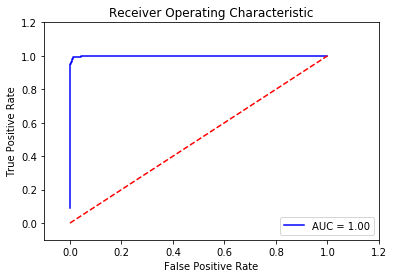

In [12]:
models = logreg_pipeline(df)

Put the input file through randomization process, then run it through the pipeline.

... Randomizing column intercept
... Randomizing column x1
... Randomizing column x2
... Randomizing column x3
... Randomizing column x4
... Randomizing column x5
... Randomizing column z
... Randomizing column pr

Train test split -- test size = 0.33
Baseline (% positives in training data): 0.484
Accuracy: 0.504
AUC Score: 0.492
Precision at top 100: 0.48
[[1329  396]
 [1241  334]]


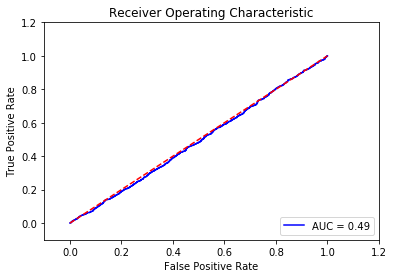

In [13]:
df_random = randomize('fake_data.csv', 'idx', ['period', 'outcome']) # creates csv named fake_data_randomized.csv
models = logreg_pipeline(df_random)

Perform statistical test on bootstrapped samples. Expect to see that model performs no better than random because data has been randomized.

In [14]:
%%capture
auc_array, precision_k_array = bootstrap_metrics(df_random, 1000, k=100, temporal=False)

AUC and precision at k scores are what we'd expect; no indication of them being statistically different from random

In [15]:
sig_test(auc_array, metric_name = 'auc', baseline = 0.5)

Performing traditional two-sided t-test for  auc
Null hypothesis: avg score is same as baseline

Baseline auc: 0.5
Sample mean auc: 0.508027
Standard error:  0.011054

t-score:  0.726149357656 p-val:  0.233958651674

Fail to reject null at significance level  0.233959
Inconclusive about whether avg auc is statistically different from baseline


0.23395865167438634

In [16]:
sig_test(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome))

Performing traditional two-sided t-test for  precision_at_k
Null hypothesis: avg score is same as baseline

Baseline precision_at_k: 0.4819
Sample mean precision_at_k: 0.501695
Standard error:  0.072558

t-score:  0.272815148319 p-val:  0.392525848262

Fail to reject null at significance level  0.392526
Inconclusive about whether avg precision_at_k is statistically different from baseline


0.39252584826184378

In [17]:
tost(auc_array, metric_name = 'auc', baseline = 0.5, m = 0.05)

Performing two one-sided t-tests (TOST) for  auc
Null hypothesis: avg score is different from baseline

Baseline auc: 0.5
Sample mean auc: 0.508027
Standard error:  0.011054

t1:  5.24951578723 p1:  9.31345589539e-08
t2:  -3.79721707192 p2:  7.75756654755e-05

Reject null at significance level  7.8e-05
Avg auc is statistically the same as random


7.7575665475504429e-05

In [18]:
tost(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome), m = 0.05)

Performing two one-sided t-tests (TOST) for  precision_at_k
Null hypothesis: avg score is different from baseline

Baseline precision_at_k: 0.4819
Sample mean precision_at_k: 0.501695
Standard error:  0.072558

t1:  0.961922765987 p1:  0.168160584263
t2:  -0.416292469349 p2:  0.338642710504
Fail to reject null at significance level  0.338643
Inconclusive about whether avg precision_at_k is statistically the same as random


0.33864271050385319

Try introducing an obvious case of data leakage by using the outcome column as a feature. Run this through the pipeline. Model performs well, as expected.


Train test split -- test size = 0.33
Baseline (% positives in training data): 0.484
Accuracy: 1.0
AUC Score: 1.0
Precision at top 100: 1.0
[[1726    0]
 [   0 1574]]


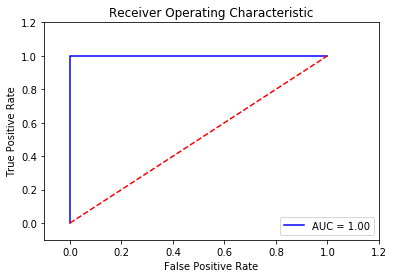

In [19]:
df['leaky_col'] = df['outcome']
models = logreg_pipeline(df)

Put the input file through randomization process. Again, introduce data leakage into the pipeline by using outcome as a feature.

... Randomizing column intercept
... Randomizing column x1
... Randomizing column x2
... Randomizing column x3
... Randomizing column x4
... Randomizing column x5
... Randomizing column z
... Randomizing column pr

Train test split -- test size = 0.33
Baseline (% positives in training data): 0.477
Accuracy: 1.0
AUC Score: 1.0
Precision at top 100: 1.0
[[1680    0]
 [   0 1620]]


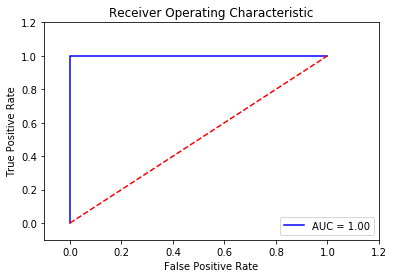

In [ ]:
df_random = randomize('fake_data.csv', 'idx', ['period', 'outcome']) # generates csv named "fake_data_randomized.csv"
df_random['leaky_col'] = df_random['outcome']
models = logreg_pipeline(df_random)


Perform statistical test on bootstrapped samples. Expect to see that model performs  better than random, thus suggesting the existence of data leakage.

In [ ]:
%%capture
auc_array, precision_k_array = bootstrap_metrics(df_random, 1000, k=100, temporal=False)

Scores are what we'd expect; they are different from random

In [ ]:
sig_test(auc_array, metric_name = 'auc', baseline = 0.5)

In [ ]:
sig_test(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome))

In [ ]:
tost(auc_array, metric_name = 'auc', baseline = 0.5, m = 0.05)

Precision at top 100 scores are what we'd expect; they are different from random

In [ ]:
tost(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome), m = 0.05)

## Case 2: Stable DGP -- Need to edit or remove because it doesn't show anything insightful

### Non-temporal example with stable DGP; data leakage through selection of variables that are highly correlated with outcome (i.e. proxy variables)

Generate data with 1000 variables for 5 periods with constant DGP. Betas are random integers between 0 and 10.

In [ ]:
frames = []
for i in range(5):
    period_df = generate_data(period = i, n_rows = 2000, m_columns = 1000, threshold = 0.5, betas = list(np.random.randint(0, 5, size=1000)), intercept = 1)
    frames.append(period_df)
df = pd.concat(frames)
df.to_csv('fake_data.csv')

Run original input file through pipeline.

In [ ]:
models = logreg_pipeline(df)

Compute correlation of each variable with outcome variable. Select top 100 highest positively-correlated variables to use as features.

Model performs worse now than when all variables are used as features. This is expected because outcome is a function of all 1000 variables in true relationship, so predictive power of 100 variables is not as high as 1000 variables.

In [ ]:
correlations = []
for i in range(1000):
    corr_coeff = df['x'+str(i + 1)].corr(df.outcome)
    correlations.append((i+1, corr_coeff))
top_100 = sorted(correlations, key=lambda x: x[1])[-100:]

In [ ]:
indices = ["x"+str(x[0]) for x in top_100]

In [ ]:
df = df[['intercept'] + indices + ['z', 'pr', 'outcome']]

In [ ]:
models = logreg_pipeline(df)

## Case 3: Regime change - intercept 
### DGP is stable over time, then the intercept suddenly changes; data leakage through non-temporal train-test split

Generate data for 5 periods with intercept change in period 2  
Dataset is in temporal order by default

In [ ]:
frames = []
for i in [0,1]:
    period_df = generate_data(period = i, n_rows = 2000, m_columns = 5, threshold = 0.5, betas = [1,1,1,1,1], intercept = 1)
    frames.append(period_df)
for i in [2,3,4]:
    period_df = generate_data(period = i, n_rows = 2000, m_columns = 5, threshold = 0.5, betas = [1,2,3,4,5], intercept = -10) 
    frames.append(period_df)
df = pd.concat(frames)
df.to_csv('fake_data.csv')

Run pipeline using appropriate temporal train-test split. Model does well.

In [ ]:
models = logreg_pipeline(df, temporal=True)

Put input file through randomization process, then run it through the pipeline.

In [ ]:
df_random = randomize('fake_data.csv', 'idx', ['period', 'outcome']) # creates csv named fake_data_randomized.csv
models = logreg_pipeline(df_random, temporal = True)

Perform statistical test on bootstrapped samples. Expect to see that model performs no better than random because data has been randomized.

In [ ]:
%%capture
auc_array, precision_k_array = bootstrap_metrics(df_random, 1000, k=100, temporal=True)

AUC and precision at k scores are what we'd expect; no indication of them being statistically different from random

In [ ]:
sig_test(auc_array, metric_name = 'auc', baseline = 0.5)

In [ ]:
sig_test(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome))

In [ ]:
tost(auc_array, metric_name = 'auc', baseline = 0.5, m = 0.05)

In [ ]:
tost(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome), m = 0.05)

Now, introduce data leakage by using non-temporal train-test split. Run this through the pipeline. Model performs well, as expected.

In [ ]:
models = logreg_pipeline(df)

Observe model performance in each period of the test data.

In [ ]:
model = models[0] # list only contains one dictionary because we ran a non-temporal pipeline

periods = np.sort(df.period.unique())

test_df = model['X_test']
test_df['y_test'] = model['y_test']
test_df['y_pred'] = model['y_pred']
test_df['probs'] = model['probs'][:, 1]

for i in periods:
    print("\nWhen test period is {}...".format(i))
    df_i = test_df[test_df.period == i]
    acc = metrics.accuracy_score(df_i.y_test, df_i.y_pred)
    auc = metrics.roc_auc_score(df_i.y_test, df_i.probs)
    prec = get_precision_at_k(df_i.y_test, df_i.y_pred, df_i.probs, 100)
    print("Accuracy: {}".format(round(acc,5)))
    print("AUC: {}".format(round(auc,5)))
    print("Precision at top 100: {}".format(round(prec, 5)))

Put the input file through randomization process, randomizing all columns except period and outcome. Again, introduce data leakage into the pipeline by using non-temporal train-test split. 

In [ ]:
df_random = randomize('fake_data.csv', 'idx', ['period', 'outcome']) # generates csv named "fake_data_randomized.csv"
models = logreg_pipeline(df_random)

Observe model performance in each period of the test data.

Note: Accuracy is higher in later periods when the data generating process changes, because the baseline % of positives has decreased so it's easier to get higher accuracy figures.  

In [ ]:
model = models[0] # list only contains one dictionary because we ran a non-temporal pipeline

periods = np.sort(df.period.unique())

test_df = model['X_test']
test_df['y_test'] = model['y_test']
test_df['y_pred'] = model['y_pred']
test_df['probs'] = model['probs'][:, 1]

for i in periods:
    print("\nWhen test period is {}....".format(i))
    df_i = test_df[test_df.period == i]
    acc = metrics.accuracy_score(df_i.y_test, df_i.y_pred)
    auc = metrics.roc_auc_score(df_i.y_test, df_i.probs)
    prec = get_precision_at_k(df_i.y_test, df_i.y_pred, df_i.probs, 100)
    print("Accuracy: {}".format(round(acc, 5)))
    print("AUC: {}".format(round(auc,5)))
    print("Precision at top 100: {}".format(round(prec, 5)))
    

Perform statistical test to confirm that model performs better than random, thus suggesting data leakage. Again, using non-temporal split as source of data leakage.

In [ ]:
%%capture
auc_array, precision_k_array = bootstrap_metrics(df_random, 1000, k=100, temporal=False)

In [ ]:
sig_test(auc_array, metric_name = 'auc', baseline = 0.5)

In [ ]:
sig_test(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome))

Even though the traditional statistical tests suggest that the scores are different from random, the tests for negligible effects suggest that these differences are negligible.  

QUESTION: What are the implications of this conclusion?

In [ ]:
tost(auc_array, metric_name = 'auc',baseline = 0.5, m = 0.05)

In [ ]:
tost(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome), m = 0.05)